In [1]:
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob

## Get data from dataset5

In [3]:
# We use only color image (not depth image)
# dataset object has the same structure as the dataset5 folder

PATH_DATASET = './dataset5/'
people = "ABCDE"
letters = "abcdefghiklmnopqrstuvwxy"
letter_indices = dict((key, value) for (key, value) in zip(letters, range(len(letters))))
dataset = {}

for p in people:
    dataset[p] = {}
    for c in letters:
        dataset[p][c] = glob.glob(PATH_DATASET + p + '/' + c + '/color_*.png')

In [4]:
# total number of images
total_images = sum([len(dataset[p][c]) for p in people for c in letters])
print("Total number of images in dataset5: ", total_images)

Total number of images in dataset5:  65774


## Train & Test data

In [5]:
# Keep 5% of all the data for testing ==> 3200 images for testing
train_data = []
train_label = []
test_data = []
test_label = []

test_prop = 0.05

for p in people:
    for c in letters:
        data = dataset[p][c]
        y = letter_indices[c]
        
        n = len(data)
        n_train = int(n*(1-test_prop)) + 1
        
        train_data.extend(data[:n_train])
        train_label.extend([y for _ in range(n_train)])
        
        test_data.extend(data[n_train:])
        
       
        test_label.extend([y for _ in range(n - n_train)])

#randomize data orders
indices = np.arange(len(train_data))
np.random.shuffle(indices)

train_data = np.array(train_data)[indices]
train_label = np.array(train_label)[indices]

#one_hot_encoding
train_label_onehot= np.zeros((len(train_label), 24))
train_label_onehot[np.arange(len(train_label)), train_label] = 1

#keep last 1000 for validation
validation_data = train_data[0:1000]
validation_label_onehot = train_label_onehot[0:1000]

train_data = train_data[1000:]
train_label_onehot = train_label_onehot[1000:]

#one_hot_encoding
test_label_onehot= np.zeros((len(test_label), 24))
test_label_onehot[np.arange(len(test_label)), test_label] = 1


print ("Train data size: ", len(train_data))
print ("Train label size: ", len(train_label))
print ("Test data size: ", len(test_data))
print ("Test label size: ", len(test_label))

Train data size:  61540
Train label size:  62540
Test data size:  3234
Test label size:  3234


Letter =  a


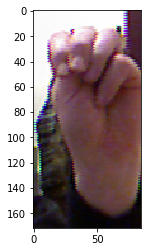

In [6]:
from matplotlib.pyplot import imshow

# check our data
k = np.random.choice(len(train_data))
img = Image.open(train_data[k])
print ("Letter = ", letters[train_label[k]])
imshow(img)

## Preprocessing

In [8]:
#Get images shape data
train_data_shapes = np.empty(len(train_data),  dtype=object)
count = 0
for i in train_data:
    train_data_shapes[count] = Image.open(i).size
    count += 1

KeyboardInterrupt: 

In [ ]:
train_data_widths = [k[0] for k in train_data_shapes]
train_data_heights = [k[1] for k in train_data_shapes]

print("min image width = ", min(train_data_widths))
print("max image width = ", max(train_data_widths))
print("avg image width = ", sum(train_data_widths)/len(train_data_widths))

print("")
print("min image height = ", min(train_data_heights))
print("max image height = ", max(train_data_heights))
print("avg image height = ", sum(train_data_heights)/len(train_data_heights))


In [ ]:
plt.scatter(train_data_widths, train_data_heights)

## Mini batch function

In [56]:
WIDTH = 120
HEIGHT = 120
C = 24

def get_image(img):
    img_resize = img.resize((WIDTH,HEIGHT),Image.ANTIALIAS)
    img_array = np.array(img_resize)
        
    #zero centered image
    img_array = img_array - img_array.mean(axis=(0,1))
    return img_array

def get_data(data, labels):
    n = len(data)
    X = np.zeros((n, WIDTH, HEIGHT, 3))
    y = np.zeros((n, C))
    
    for i in range(n):
        img = Image.open(data[i])
        X[i] = get_image(img)
        y[i] = labels[i]
    
    return X,y

def get_batch(batch_number, batch_size = 128):
    #return X, y with X resized images and y labels
    min_index = batch_number * batch_size
    max_index = min(len(train_data), (batch_number+1)*batch_size)
    return get_data(train_data[min_index: max_index], train_label_onehot[min_index: max_index])

def get_test_batch(batch_number, batch_size = 128):
    #return X, y with X resized images and y labels
    min_index = batch_number * batch_size
    max_index = min(len(test_data), (batch_number+1)*batch_size)
    return get_data(test_data[min_index: max_index], test_label_onehot[min_index: max_index])

In [10]:
X_validation, y_validation = get_data(validation_data, validation_label_onehot)

In [11]:
X_validation.shape

(1000, 120, 120, 3)

## Model

In [12]:
import tensorflow as tf

D = 43200 #120*120*3

X = tf.placeholder(tf.float32, [None, WIDTH, HEIGHT, 3])
W = tf.Variable(tf.zeros([D, C]))
b = tf.Variable(tf.zeros([C]))

init = tf.global_variables_initializer()

# model
logits = tf.matmul(tf.reshape(X, [-1, D]), W) + b
#Y = tf.nn.softmax(output)
# placeholder for correct labels
Y_ = tf.placeholder(tf.float32, [None, C])

# loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y_))

#cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y))

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(logits,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)

In [13]:
batch_size = 128
number_batch = int(len(train_data)/batch_size)
print("number of batch = ", number_batch)

number of batch =  480


In [30]:
losses = []
train_accuracies = []
validation_accuracies = []

saver = tf.train.Saver()

epochs = 10

with tf.Session() as sess:
    sess.run(init)
    
    for _ in range(epochs):
        for i in range(number_batch):
            # load batch of images and correct answers
        
            batch_X, batch_Y = get_batch(batch_number = i)
            batch_data ={X: batch_X, Y_: batch_Y}
       
            # train
            sess.run(train_step, feed_dict=batch_data)
        
        
            if i> 0 and i%50 == 0:
                train_a, loss = sess.run([accuracy, cross_entropy], feed_dict=batch_data)
                losses.append(loss)
                train_accuracies.append(train_a)
            
                valid_a = sess.run(accuracy, feed_dict={X: X_validation, Y_: y_validation})
                validation_accuracies.append(valid_a)
            
                print (i, ":", " train loss = ", loss,"; train accuracy = ", train_a, "; test accuracy = ", valid_a)   
            
    # Save the variables to disk.
    save_path = saver.save(sess, "./tmp/one_layer/model_1layer.ckpt")
    print("Model saved in file: %s" % save_path)


50 :  train loss =  4580.76 ; train accuracy =  0.5 ; test accuracy =  0.385
100 :  train loss =  1966.7 ; train accuracy =  0.625 ; test accuracy =  0.483
150 :  train loss =  875.707 ; train accuracy =  0.75 ; test accuracy =  0.552
200 :  train loss =  2019.39 ; train accuracy =  0.726562 ; test accuracy =  0.582
250 :  train loss =  1355.61 ; train accuracy =  0.742188 ; test accuracy =  0.628
300 :  train loss =  676.764 ; train accuracy =  0.796875 ; test accuracy =  0.612
350 :  train loss =  2366.82 ; train accuracy =  0.601562 ; test accuracy =  0.573
400 :  train loss =  850.944 ; train accuracy =  0.828125 ; test accuracy =  0.666
450 :  train loss =  589.983 ; train accuracy =  0.851562 ; test accuracy =  0.658
50 :  train loss =  849.088 ; train accuracy =  0.8125 ; test accuracy =  0.643
100 :  train loss =  1398.66 ; train accuracy =  0.765625 ; test accuracy =  0.631
150 :  train loss =  411.044 ; train accuracy =  0.875 ; test accuracy =  0.7
200 :  train loss =  1315.

## Result on Test

In [65]:
def test_accuracy():
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, "./tmp/one_layer/model_1layer.ckpt")
        print("Model restored.")
        N = len(test_data)    
        batch_size = 128
        batch_number = int(N/batch_size) + 1
        sum_correct = 0.
        for i in range(batch_number):
            batch_X, batch_Y = get_test_batch(i)
            n = batch_X.shape[0]
            a = sess.run(accuracy, feed_dict={X: batch_X, Y_: batch_Y})
            sum_correct += a*n
        
        test_accuracy = sum_correct/N
        print("final test accuracy = ", test_accuracy)
        
test_accuracy()

INFO:tensorflow:Restoring parameters from ./tmp/one_layer/model_1layer.ckpt
Model restored.
final test accuracy =  0.813543599037


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

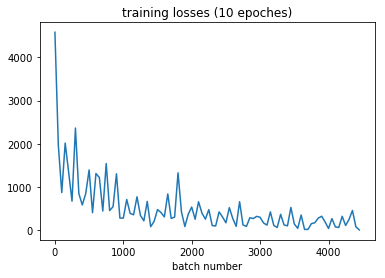

In [51]:
plt.plot(np.arange(len(losses))*50,losses)
plt.title("training losses (10 epoches)")
plt.xlabel("batch number")

In [33]:
import pandas as pd 

In [35]:
results = pd.DataFrame({ 
    "losses":losses, 
    "train_accuracies":train_accuracies,
    "validation_accuracies":validation_accuracies
    })
results.to_csv("./results/one_layer_1.csv")

In [54]:
def test_result():
    with tf.Session() as sess:
        m = 100

In [55]:
m

NameError: name 'm' is not defined

In [59]:
len(test_data)

3234

In [60]:
3234/128

25.265625